<a href="https://colab.research.google.com/github/sundar-nallalagappan/Coursera_Timeseries/blob/main/Time_series_RNN_Lstm_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print("sairam")

sairam


In [2]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from keras.layers import Dense, LSTM, SimpleRNN, Bidirectional, Flatten
from keras.models import Sequential

import numpy as np
import matplotlib.pyplot as plt

2.12.0


# Utility helper function

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

# Generate data

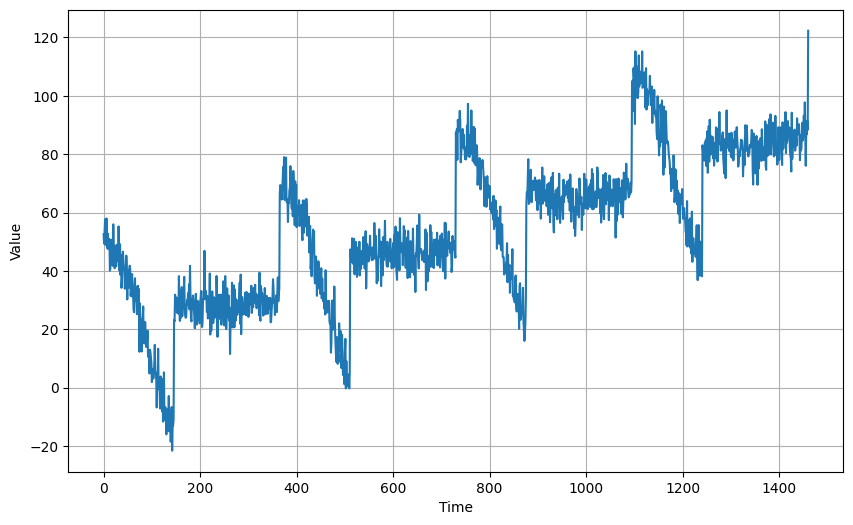

In [4]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

In [5]:
series, time

(array([ 52.48357 ,  49.35275 ,  53.314735, ...,  91.37325 ,  88.32383 ,
        122.30772 ], dtype=float32),
 array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.458e+03, 1.459e+03,
        1.460e+03], dtype=float32))

# Split the data

(1000,) (1000,)
(461,) (461,)


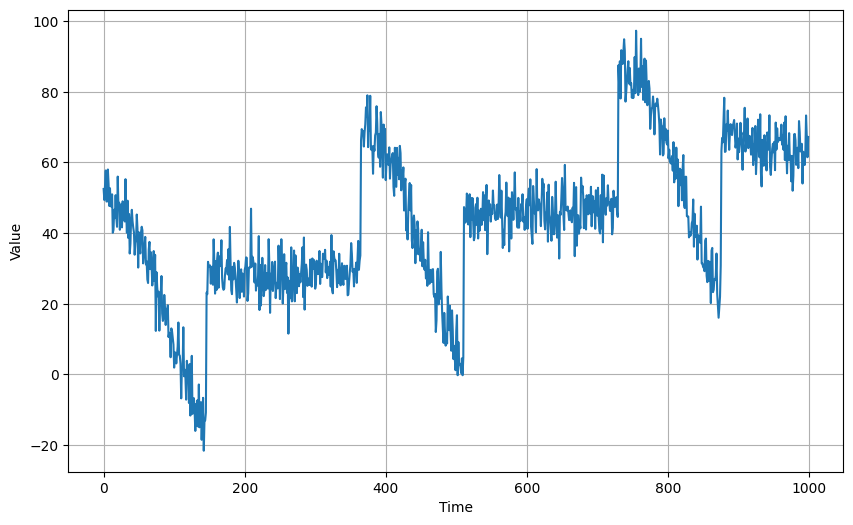

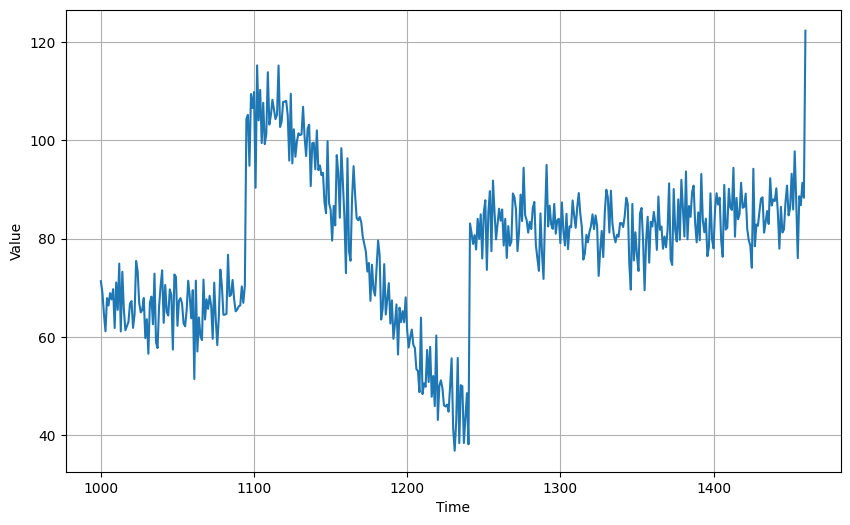

In [6]:
split_time = 1000

X_train     = time[:split_time]
value_train = series[:split_time]

X_test      = time[split_time:]
value_test  = series[split_time:]

print(X_train.shape, value_train.shape)
print(X_test.shape, value_test.shape)

plot_series(X_train, value_train)
plot_series(X_test , value_test)

# Window helper function

In [7]:
def window_sized_data(series, window_size, shuffle_buffer_size, batch_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(window_size+1))
  ds = ds.map(lambda window: (window[:-1], window[-1]))
  ds = ds.shuffle(shuffle_buffer_size)
  ds = ds.batch(batch_size).prefetch(1)
  return ds

In [8]:
window_size         = 30
shuffle_buffer_size = 1000
batch_size          = 32

ds = window_sized_data(value_train, window_size, shuffle_buffer_size, batch_size)

for x, y in ds:
  print("X:", x)
  print("Y:", y)

Streaming output truncated to the last 5000 lines.
   67.919136    68.053764    66.2601      59.30633     63.911392
   64.14101     58.376602    71.69516     68.57505     63.09382
   64.34379     65.262314    54.023083    63.007553    60.845512  ]
 [ 64.17726     57.294388    60.83839     47.617447    55.74531
   58.221962    53.5481      57.82629     49.2742      58.26888
   62.078083    48.130997    47.079636    55.936584    55.930805
   44.782898    44.661682    44.720486    38.77553     40.274677
   39.219364    39.77539     42.817646    43.541412    49.504898
   36.145657    45.44724     38.847263    39.06503     42.08534   ]
 [ 37.237713    38.097908    45.242546    41.222683    30.229015
   40.196377    36.174564    34.231815    40.183838    41.78223
   40.778324    31.413605    33.544636    36.221428    38.910835
   31.098982    32.022236    26.868631    25.863333    35.345516
   37.49725     29.783985    34.584698    30.793396    25.17319
   29.614908    34.90301     26.434551

# Build Model

In [55]:
model = Sequential([
    #tf.keras.layers.Input(shape=[window_size]),
    SimpleRNN(40, return_sequences=True, input_shape=[window_size,1]),
    SimpleRNN(40),
    Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

learning_rate = 1e-8

optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_18 (SimpleRNN)   (None, 30, 40)            1680      
                                                                 
 simple_rnn_19 (SimpleRNN)   (None, 40)                3240      
                                                                 
 dense_9 (Dense)             (None, 1)                 41        
                                                                 
 lambda_6 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


In [56]:
def window_sized_data_nobatch(series, window_size, shuffle_buffer_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(window_size+1))
  ds = ds.map(lambda window: (window[:-1], window[-1]))
  ds = ds.shuffle(shuffle_buffer_size)
  return ds

ds = window_sized_data_nobatch(value_train, window_size, shuffle_buffer_size)

X = []
Y = []
for x, y in ds:
  X.append(x.numpy())
  Y.append(y.numpy())


In [57]:
X[0], Y[0]

(array([27.353228, 31.072536, 29.55496 , 25.05581 , 27.14825 , 25.743662,
        25.281895, 32.497025, 30.054634, 24.825788, 32.809357, 29.869114,
        32.418423, 31.52398 , 24.252817, 25.619074, 32.178864, 31.51689 ,
        28.383394, 29.097626, 34.92262 , 25.599964, 31.317053, 27.594557,
        27.541286, 34.147957, 32.805748, 32.771015, 35.255863, 28.8587  ],
       dtype=float32),
 32.188858)

In [58]:
X_final = np.array(X)
Y_final = np.array(Y)

print(X_final.shape, Y_final.shape)

(970, 30) (970,)


In [47]:
X_final = np.expand_dims(X_final, axis=2)

In [48]:
X_final.shape, Y_final.shape

((970, 30, 1), (970,))

In [59]:
history = model.fit(X_final, Y_final , epochs=250)

Epoch 1/250
31/31 [==============================] - 2s 12ms/step - loss: 46.6732 - mae: 47.1732
Epoch 2/250
31/31 [==============================] - 0s 13ms/step - loss: 42.3195 - mae: 42.8190
Epoch 3/250
31/31 [==============================] - 0s 13ms/step - loss: 37.5935 - mae: 38.0927
Epoch 4/250
31/31 [==============================] - 0s 13ms/step - loss: 32.9968 - mae: 33.4956
Epoch 5/250
31/31 [==============================] - 0s 13ms/step - loss: 28.7686 - mae: 29.2672
Epoch 6/250
31/31 [==============================] - 1s 17ms/step - loss: 25.0610 - mae: 25.5583
Epoch 7/250
31/31 [==============================] - 1s 21ms/step - loss: 21.9379 - mae: 22.4359
Epoch 8/250
31/31 [==============================] - 1s 20ms/step - loss: 19.3750 - mae: 19.8712
Epoch 9/250
31/31 [==============================] - 1s 20ms/step - loss: 17.2988 - mae: 17.7951
Epoch 10/250
31/31 [==============================] - 1s 21ms/step - loss: 15.6946 - mae: 16.1890
Epoch 11/250
31/31 [=========

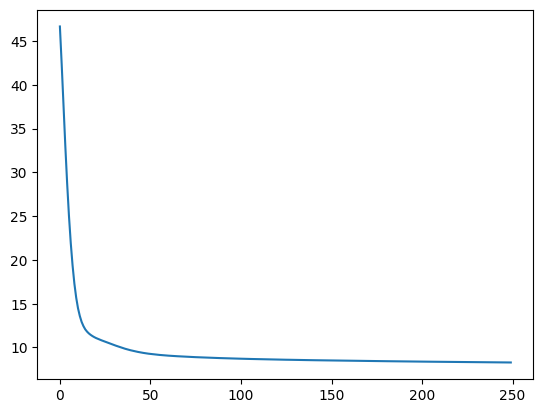

In [61]:
plt.plot(range(250), history.history['loss'])

1/1 [==============================] - 0s 23ms/step


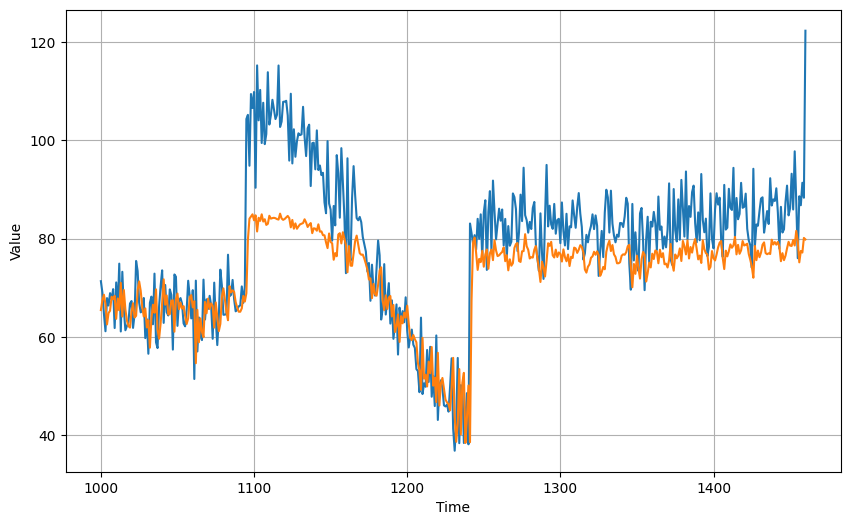

In [62]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(X_test, (value_test, results))

In [63]:
results

array([65.4603  , 67.47141 , 68.59143 , 66.65083 , 62.543846, 64.85535 ,
       65.33929 , 68.17353 , 67.664566, 68.38488 , 63.686127, 67.82759 ,
       65.42827 , 71.008125, 64.156685, 69.54254 , 65.58562 , 63.323982,
       62.224525, 61.90192 , 65.15278 , 66.85678 , 63.96045 , 64.29715 ,
       69.52797 , 71.28844 , 69.395546, 66.08133 , 64.147064, 65.80413 ,
       61.925793, 63.393593, 57.807446, 63.79773 , 66.5533  , 64.91293 ,
       69.67891 , 61.50981 , 59.635563, 62.726868, 66.92119 , 71.72065 ,
       66.56318 , 68.43986 , 64.5619  , 64.63665 , 67.36011 , 67.47067 ,
       61.06721 , 67.701065, 68.838   , 65.65407 , 66.96888 , 65.75923 ,
       66.266174, 64.28115 , 62.63162 , 63.78607 , 68.09436 , 68.50541 ,
       66.00398 , 67.273926, 54.653187, 65.51302 , 58.91461 , 63.779808,
       61.006546, 59.947205, 67.12697 , 64.815445, 67.79534 , 65.69374 ,
       66.828606, 66.30398 , 61.89713 , 67.01898 , 64.05117 , 61.181896,
       62.65723 , 68.11021 , 69.883354, 67.54141 , 

In [64]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(value_test, results).numpy())
print(tf.keras.metrics.mean_absolute_error(value_test, results).numpy())

109.85203
7.9539337


In [65]:
model = Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    SimpleRNN(40, return_sequences=True),
    SimpleRNN(40),
    Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

learning_rate = 1e-6

optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

#model.summary()

In [66]:
window_size         = 30
shuffle_buffer_size = 1000
batch_size          = 32

ds = window_sized_data(value_train, window_size, shuffle_buffer_size, batch_size)



In [67]:
# Train the model
history = model.fit(ds,epochs=100)

Epoch 1/100
31/31 [==============================] - 2s 14ms/step - loss: 16.1318 - mae: 16.6274
Epoch 2/100
31/31 [==============================] - 1s 12ms/step - loss: 11.9269 - mae: 12.4191
Epoch 3/100
31/31 [==============================] - 1s 14ms/step - loss: 10.5891 - mae: 11.0804
Epoch 4/100
31/31 [==============================] - 1s 13ms/step - loss: 9.6771 - mae: 10.1640
Epoch 5/100
31/31 [==============================] - 1s 14ms/step - loss: 9.0457 - mae: 9.5315
Epoch 6/100
31/31 [==============================] - 1s 13ms/step - loss: 8.7048 - mae: 9.1905
Epoch 7/100
31/31 [==============================] - 1s 13ms/step - loss: 8.1697 - mae: 8.6555
Epoch 8/100
31/31 [==============================] - 1s 13ms/step - loss: 7.9133 - mae: 8.3958
Epoch 9/100
31/31 [==============================] - 1s 13ms/step - loss: 7.7464 - mae: 8.2321
Epoch 10/100
31/31 [==============================] - 1s 13ms/step - loss: 7.5686 - mae: 8.0492
Epoch 11/100
31/31 [======================

1/1 [==============================] - 0s 46ms/step


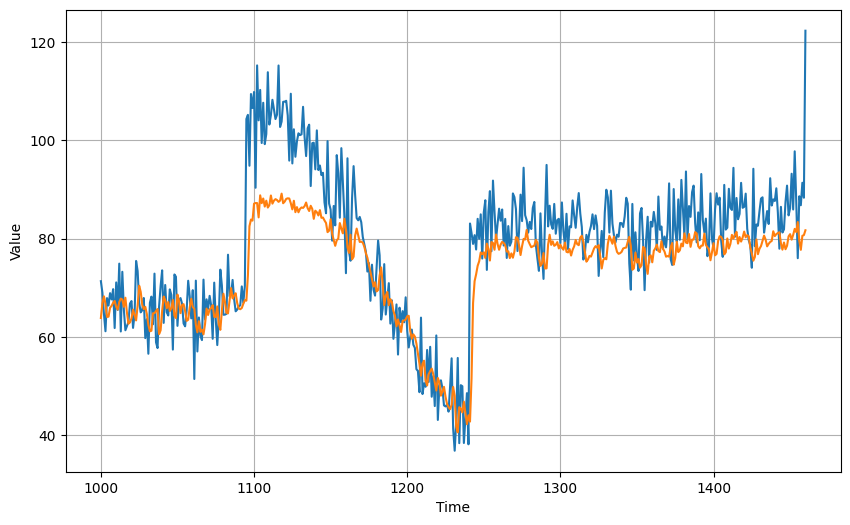

In [39]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(X_test, (value_test, results))

In [40]:
results

array([63.853054, 66.84395 , 68.26404 , 66.74978 , 64.071335, 64.12638 ,
       65.93411 , 66.328316, 66.93968 , 67.328415, 66.139465, 65.55482 ,
       67.11294 , 67.804825, 67.60902 , 66.12435 , 67.97929 , 64.99425 ,
       62.69195 , 62.961815, 63.77825 , 65.5611  , 64.451126, 63.355427,
       66.420906, 70.41786 , 69.17153 , 66.55907 , 65.652695, 66.121704,
       64.68978 , 62.46451 , 61.158257, 61.252014, 64.81674 , 64.8278  ,
       65.273125, 65.67673 , 60.5708  , 61.34406 , 65.33143 , 68.222466,
       67.50201 , 65.83774 , 67.109886, 65.28345 , 65.78032 , 67.52135 ,
       64.349335, 63.84594 , 68.61279 , 67.321014, 64.83616 , 66.47628 ,
       66.66742 , 65.25123 , 63.263607, 63.491726, 66.007454, 67.783554,
       66.08852 , 65.72554 , 62.51908 , 60.939796, 63.198654, 61.040062,
       61.49785 , 60.517323, 62.614483, 65.76771 , 64.46427 , 65.60774 ,
       65.853004, 66.46504 , 64.098465, 64.04274 , 66.207306, 62.53141 ,
       61.44404 , 65.37199 , 68.79278 , 67.117   , 

In [41]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(value_test, results).numpy())
print(tf.keras.metrics.mean_absolute_error(value_test, results).numpy())

85.83079
6.8965178
